In [4]:
#import wandb
import numpy as np
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)


In [5]:
import os
os.environ.get("LD_LIBRARY_PATH")

'/eos/home-g/gkrzmanc/miniforge3/lib:/home/gkrzmanc/env/lib:'

In [6]:
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import torch
print("CUDA available:", torch.cuda.is_available())  # in case needed


def get_dataset():
    path = "/afs/cern.ch/work/g/gkrzmanc/mlpf_results/clustering_gt_with_pid_and_mean_features/cluster_features"
    r = {}
    n = 0
    #nmax = 257
    for file in os.listdir(path):
        #n += 1
        #if n > nmax:
        #    break
        f = pickle.load(open(os.path.join(path, file), "rb"))
        for key in f:
            if key not in r:
                r[key] = f[key]
            else:
                r[key] = torch.concatenate((r[key], f[key]), axis=0)
    x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
    h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg"]
    h1_names = ["hit_eta_avg", "hit_phi_avg"]
    print("x shape:", r["x"].shape)
    xyz = r["node_features_avg"][:, [0,1,2]].cpu()
    eta_phi = torch.stack([calculate_eta(xyz[:, 0], xyz[:, 1], xyz[:, 2]), calculate_phi(xyz[:, 0], xyz[:, 1])], dim=1)
    return torch.concatenate([r["x"], xyz, eta_phi], dim=1), x_names + h_names + h1_names, r["true_e_corr"], r["e_true"], r["e_reco"], r["y_particles"][:, 6]


def get_split(ds):
    from sklearn.model_selection import train_test_split
    x, _, y, etrue, _, pids = ds
    xtrain, xtest, ytrain, ytest, energiestrain, energiestest, pid_train, pid_test = train_test_split(
        x, y, etrue, pids, test_size=0.2, random_state=42
    )
    return xtrain, xtest, ytrain, ytest, energiestrain, energiestest, pid_train, pid_test

def get_gb():
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(verbose=1)
    return model

def get_nn():
    from sklearn.neural_network import MLPRegressor
    model = MLPRegressor(hidden_layer_sizes=(30, 30), verbose=True, max_iter=1000)
    return model

def calculate_phi(x, y):
    return np.arctan2(y, x)

def calculate_eta(x, y, z):
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)
    return -np.log(np.tan(theta/2))

def main(ds, train_only_on_tracks=False, train_only_on_neutral=False, train_energy_regression=False):
    split = list(get_split(ds))
    gpus = [0]
    #wandb.init(project="mlpf_debug_energy_corr", entity="fcc_ml")
    #wandb.run.name = "Debug E correction"
    model = "nn"
    #wandb.run.model = model
    if model == "gradboost":
        model = get_gb()
    elif model == "nn":
        model = get_nn()
    if train_only_on_tracks:
        mask = (split[0][:, 3] > 0) & (split[0][:, 7] == 1)
        split[0] = split[0][mask]
        split[2] = split[2][mask]
        split[4] = split[4][mask]
    elif train_only_on_neutral:
        mask = (split[0][:, 3] == 0) & (split[0][:, 7] == 0)
        split[0] = split[0][mask]
        split[2] = split[2][mask]
        split[4] = split[4][mask]
    if not train_energy_regression:
        result = model.fit(split[0], split[2])
        print("Fitted model:", result)
        # validation
        ypred = model.predict(split[1])
        ytrue = split[3]
        energies = split[5]
        return ytrue, ypred, energies, split[1], model, split
    else:
        result = model.fit(split[0], split[4])
        print("Fitted model:", result)
        # validation
        epred = model.predict(split[1])
        ytrue = split[3]
        ysum = split[1][:, 6]
        ypred = epred / ysum - 1
        energies = split[5]
        return ytrue, epred, energies, split[1], model, split
        # log scatterplots of validation results per energy


def main_pandora():
    # just take the track p and energy of the hits for regression - so, "quasi-pandora"
    ds = get_dataset()
    print("Loaded dataset")
    split = get_split(ds)
    gpus = [0]
    #wandb.init(project="mlpf_debug_energy_corr", entity="fcc_ml")
    #wandb.run.name = "Debug E correction"
    model = "gradboost"
    #wandb.run.model = model
    if model == "gradboost":
        model = get_gb()
        result = model.fit(split[0][:, [3, 6]], split[2])
        print("Fitted model:", result)
        # validation
        ypred = model.predict(split[1][:, [3, 6]])
        ytrue = split[3]
        energies = split[5]
        return ytrue, ypred, energies, split[1][:, [3, 6]], model, split
        # log scatterplots of validation results per energy
    else:
        raise NotImplementedError



CUDA available: True


In [7]:
import numpy as np
ds = get_dataset()
print("Loaded dataset")

x shape: torch.Size([123944, 8])
Loaded dataset


In [8]:
ds[0].shape

torch.Size([123944, 13])

In [9]:
neutral_yt, neutral_yp, neutral_en, _, neutral_model, neutral_split = main(ds=ds, train_only_on_neutral=True, train_energy_regression=True)

Iteration 1, loss = 4248.92911581
Iteration 2, loss = 87.23797814
Iteration 3, loss = 55.56272901
Iteration 4, loss = 41.50079106
Iteration 5, loss = 33.56313489
Iteration 6, loss = 28.13198357
Iteration 7, loss = 23.88790915
Iteration 8, loss = 20.56305860
Iteration 9, loss = 17.83780808
Iteration 10, loss = 15.76376725
Iteration 11, loss = 14.11450549
Iteration 12, loss = 12.66629874
Iteration 13, loss = 11.45109087
Iteration 14, loss = 10.43265713
Iteration 15, loss = 9.57991867
Iteration 16, loss = 8.84193158
Iteration 17, loss = 8.08101542
Iteration 18, loss = 7.51090261
Iteration 19, loss = 7.02986676
Iteration 20, loss = 6.50564236
Iteration 21, loss = 5.98946444
Iteration 22, loss = 5.71038783
Iteration 23, loss = 5.28006775
Iteration 24, loss = 4.91485560
Iteration 25, loss = 4.65654400
Iteration 26, loss = 4.43817213
Iteration 27, loss = 4.27931222
Iteration 28, loss = 4.02281341
Iteration 29, loss = 3.79268841
Iteration 30, loss = 3.68141713
Iteration 31, loss = 3.31903352
I

In [10]:
yt_regression, yp_regression, en_regression, _, model_regression, split_regression = main(ds=ds, train_only_on_tracks=True, train_energy_regression=True)

Iteration 1, loss = 353.40339885
Iteration 2, loss = 41.35946814
Iteration 3, loss = 24.87912739
Iteration 4, loss = 17.42664019
Iteration 5, loss = 12.87155106
Iteration 6, loss = 10.40541930
Iteration 7, loss = 8.87883345
Iteration 8, loss = 7.56006600
Iteration 9, loss = 6.71805859
Iteration 10, loss = 5.86856214
Iteration 11, loss = 5.27663557
Iteration 12, loss = 4.76307896
Iteration 13, loss = 4.15630520
Iteration 14, loss = 3.88062811
Iteration 15, loss = 3.61096096
Iteration 16, loss = 3.43681836
Iteration 17, loss = 3.28541864
Iteration 18, loss = 2.95728576
Iteration 19, loss = 2.93419957
Iteration 20, loss = 2.72827064
Iteration 21, loss = 2.74279900
Iteration 22, loss = 2.50956309
Iteration 23, loss = 2.50498699
Iteration 24, loss = 2.36460123
Iteration 25, loss = 2.26065880
Iteration 26, loss = 2.13808290
Iteration 27, loss = 2.18207845
Iteration 28, loss = 2.23256454
Iteration 29, loss = 2.20901479
Iteration 30, loss = 2.10764039
Iteration 31, loss = 2.11164078
Iteration 

In [11]:
split_regression = list(get_split(ds))

In [ ]:
def plot(ytrue, ypred, energies):
        bins = [0, 1, 2, 5, 10, 15, 30, 50]
        fig, ax = plt.subplots(4, 1, figsize=(8, 15))
        for i in range(len(bins) - 1):
            mask = (energies > bins[i]) & (energies < bins[i + 1])
            ax[0].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i+1]} GeV", alpha=0.2)
            # plot identity line
            ax[0].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].scatter(1+ytrue[mask], 1+ypred[mask], label=f"{bins[i]}-{bins[i + 1]} GeV", alpha=0.2)
        ax[0].set_xlabel("True E corr. fact.")
        ax[0].set_ylabel("Predicted E corr. fact.")
        ax[1].set_xlabel("1+True E corr. fact.")
        ax[1].set_ylabel("1+Predicted E corr. fact.")
        # ax1 is in logscale
        ax[1].set_yscale("log")
        ax[1].set_xscale("log")
        ax[0].legend()
        ax[1].legend()
        # ax 2 and 3 just plot a histogram of the true and predicted values
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(round(ytrue.min().item(), 2)) + " max:" + str(round(ytrue.max().item(), 2)))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        ##########################
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].hist(ypred, bins=500, histtype="step", label="Predicted")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(ytrue.min().item()) + " max:" + str(ytrue.max().item()))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        #wandb.log({"validation": wandb.Image(fig)})

plot(yt, yp, en)

In [ ]:
# ... Plotting with the energy of the sum of the hits...
plot(yt, yp, split[1][:, 6])

In [ ]:
def plot1(ytrue, ypred, energies):
        bins = [0, 1, 2, 5, 10, 15, 30, 50]
        fig, ax = plt.subplots(4, 1, figsize=(8, 15))
        for i in range(len(bins) - 1):
            if i not in [0, 1, 2]:
                continue
            mask = (energies > bins[i]) & (energies < bins[i + 1])
            ax[0].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i+1]} GeV", alpha=0.2)
            # plot identity line
            ax[0].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i + 1]} GeV", alpha=0.2)
        ax[0].set_xlabel("True E corr. fact.")
        ax[0].set_ylabel("Predicted E corr. fact.")
        ax[1].set_xlabel("True E corr. fact.")
        ax[1].set_ylabel("Predicted E corr. fact.")
        # ax1 is in logscale
        ax[1].set_yscale("log")
        ax[1].set_xscale("log")
        ax[0].legend()
        ax[1].legend()
        # ax 2 and 3 just plot a histogram of the true and predicted values
        #ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(round(ytrue.min().item(), 2)) + " max:" + str(round(ytrue.max().item(), 2)))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        ##########################
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].hist(ypred, bins=500, histtype="step", label="Predicted")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(ytrue.min().item()) + " max:" + str(ytrue.max().item()))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        #wandb.log({"validation": wandb.Image(fig)})
plot1(yt, yp, en)

In [16]:
import shap
import numpy as np
te = shap.TreeExplainer(model)
shap_vals = te.shap_values(np.array(split[1]))

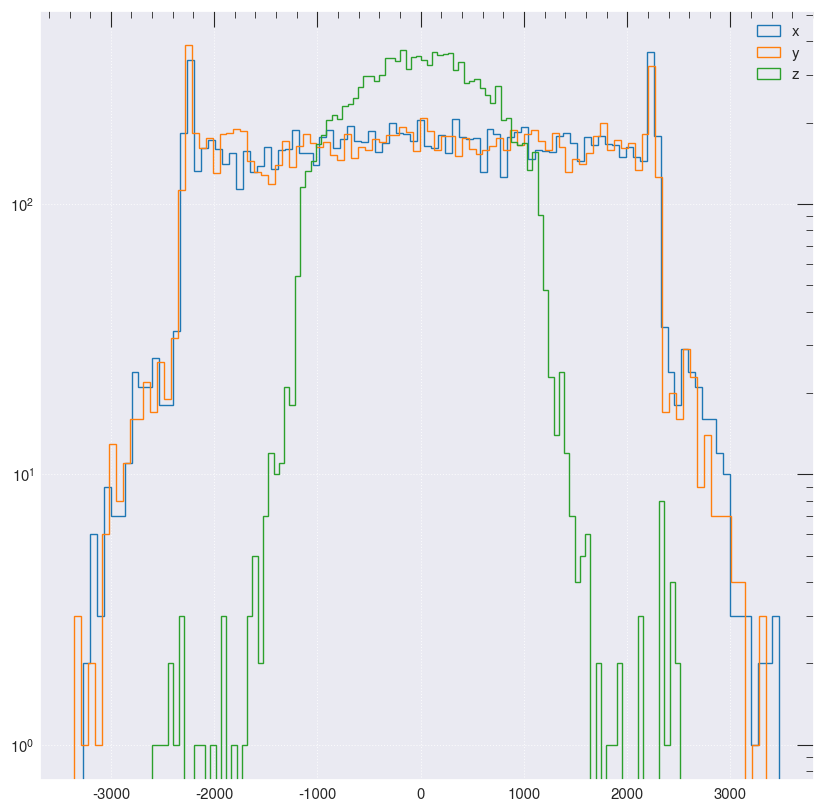

In [13]:
fig, ax = plt.subplots()
# hist of xyz
ax.hist(split_regression[1][:, 8], bins=100, histtype="step", label="x")
ax.hist(split_regression[1][:, 9], bins=100, histtype="step", label="y")
ax.hist(split_regression[1][:, 10], bins=100, histtype="step", label="z")
ax.set_yscale("log")
ax.legend()
fig.show()


In [ ]:
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
shap.summary_plot(shap_vals, split[1], feature_names=x_names, use_log_scale=True, show=False)
plt.savefig("/eos/user/g/gkrzmanc/2024/12_3_/shap_summary_tracks_1.pdf")

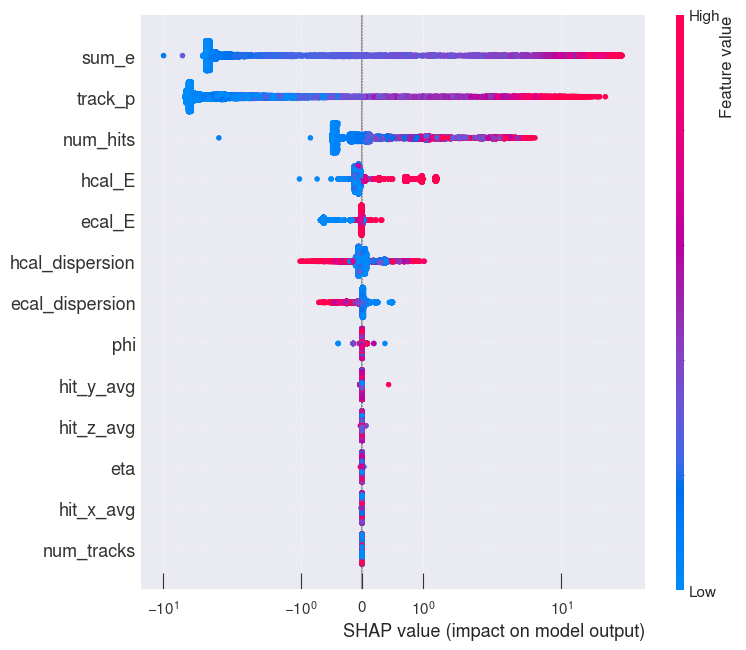

In [25]:
import shap
import numpy as np

te = shap.TreeExplainer(model_regression)
shap_vals_r = te.shap_values(np.array(split_regression[1]))
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg", "eta", "phi"]
shap.summary_plot(shap_vals_r, split_regression[1], feature_names=x_names+h_names, use_log_scale=True, show=False)
plt.savefig("/eos/user/g/gkrzmanc/2024/12_3_/shap_summary_tracks_Regression_with_XYZ.pdf")

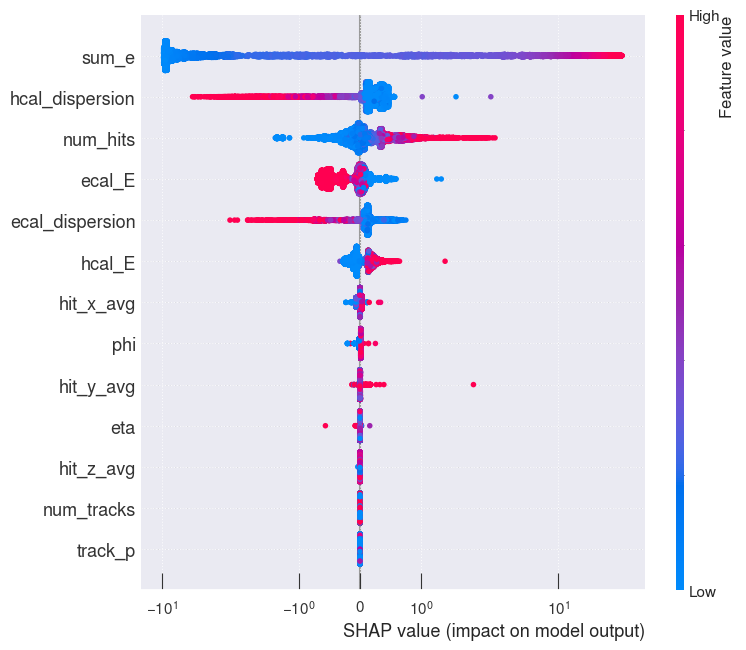

In [32]:
import shap
import numpy as np

te = shap.TreeExplainer(neutral_model)
shap_vals_r = te.shap_values(np.array(neutral_split[1]))
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg", "eta", "phi"]
shap.summary_plot(shap_vals_r, neutral_split[1], feature_names=x_names+h_names, use_log_scale=True, show=False)
plt.savefig("/eos/user/g/gkrzmanc/2024/12_3_/shap_summary_Neutrals_Regression_with_XYZ.pdf")


In [ ]:
# just plot sum_e vs. true_e_corr.factor
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(split[1][:, 6], 1+yt, label="True", alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Sum E")
ax.set_ylabel("1 + True E corr. factor")
fig.show()

In [ ]:
# just plot sum_e vs. true_e_corr.factor
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(split[1][:, 3], 1+yt, alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Sum E")
ax.set_ylabel("1 + True E corr. factor")
fig.show()

tensor(24214) 24214


NameError: name 'yt_pandora' is not defined

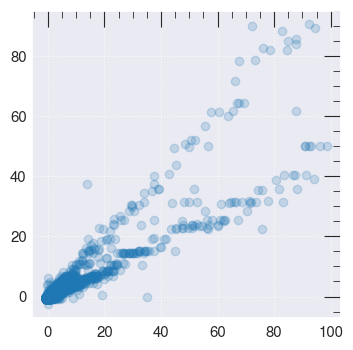

In [13]:
energies = split[1][:, 6]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
#mask = (energies > 0) & (energies < 1)
mask = (split[1][:, 3] > 0) & (split[1][:, 7] > 0)  # TRACKS
mask = energies > 0
print(mask.sum(), len(mask))
ax.scatter(yt[mask], yp[mask], label=f"All features", alpha=0.2)
ax.scatter(yt_pandora[mask], yp_pandora[mask], label=f"E+p", alpha=0.2)
# correlation coeff.
from scipy.stats import pearsonr
r, p = pearsonr(yt[mask], yp[mask])
r_pandora, p_pandora = pearsonr(yt_pandora[mask], yp_pandora[mask])
print("Correlation coeff. all features:", r, p)
print("Correlation coeff. E+p:", r_pandora, p_pandora)
ax.plot([0, 100], [0, 100], color="gray", linestyle="--")
ax.set_xlabel("True E corr. fact.")
ax.set_ylabel("Predicted E corr. fact.")
ax.legend()
fig.show()

In [ ]:
# define bins of the predicted corr. factor
bins = [-1, -0.75, -0.5, -0.25, -0.1, 0.1, 0.25, 0.5, 0.75, 1, 3, 5, 7, 10, 15, 30, 50, 100]
bins = [-1, -0.5, -0.1, 0.1, 0.5, 1, 5, 10, 50, 100]
n_plots = len(bins) - 1
corr_coeffs_ep, corr_coefs = [], []
bin_avg = []
fig, ax = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))
track_filter = ((split[1][:, 3] > 0) & (split[1][:, 7] > 0).clone().detach().cpu().numpy())
import numpy as np
for i in range(len(bins) - 1):
    mask = (yp > bins[i]) & (yp < bins[i + 1]) & (track_filter).detach().cpu().numpy()
    bin_avg.append(yp[mask].mean())
    ax[i].scatter(yt[mask], yp[mask], alpha=0.2, label="all feat.")
    ax[i].scatter(yt_pandora[mask], yp_pandora[mask], alpha=0.2, label="E+p")
    cc = round(pearsonr(yt[mask], yp[mask])[0], 2)
    cc_ep = round(pearsonr(yt_pandora[mask], yp_pandora[mask])[0], 2)
    corr_coeffs_ep.append(cc_ep)
    corr_coefs.append(cc)
    ax[i].set_title(f"{bins[i]}-{bins[i+1]} (cc = {cc} / {cc_ep})")
    #ax[i].plot([0, 100], [0, 100], color="gray", linestyle="--")
    ax[i].set_xlabel("True E corr. fact.")
    ax[i].set_ylabel("Predicted E corr. fact.")
    ax[i].legend()
fig.tight_layout()
#fig.savefig("/eos/user/g/gkrzmanc/2024/xgb_correction/energy_corr_vs_true_corr_regions.pdf")
fig.show()


In [ ]:

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(bin_avg, corr_coefs, ".--", label="All features")
ax.plot(bin_avg, corr_coeffs_ep, ".--", label="E+p")
ax.set_xlabel("Average predicted E corr. factor")
ax.set_ylabel("Correlation coefficient")
ax.legend()
fig.show()


In [13]:
import numpy as np
def get_std68(theHist, bin_edges, percentage=0.683, epsilon=0.01):
    # theHist, bin_edges = np.histogram(data_for_hist, bins=bins, density=True)
    wmin = 0.2
    wmax = 1.0

    weight = 0.0
    points = []
    sums = []

    # fill list of bin centers and the integral up to those point
    for i in range(len(bin_edges) - 1):
        weight += theHist[i] * (bin_edges[i + 1] - bin_edges[i])
        points.append([(bin_edges[i + 1] + bin_edges[i]) / 2, weight])
        sums.append(weight)
    low = wmin
    high = wmax
    width = 100
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
            if abs(wy - percentage) < epsilon:
                wx = points[j][0] - points[i][0]
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    width = wx

    return 0.5 * (high - low), low, high


def mean_without_outliers(data):
    remove_count = int(len(data) * 0.03)
    # Sort the array
    sorted_arr = np.sort(data)
    # Remove the lowest and highest 1% of the elements
    trimmed_arr = sorted_arr[remove_count:-remove_count]
    # Calculate the mean of the trimmed array
    mean = np.mean(trimmed_arr)
    return mean


def obtain_MPV_and_68_raw(data_for_hist, bins_per_binned_E=np.arange(-1, 5, 0.01), epsilon=0.01):
    hist, bin_edges = np.histogram(data_for_hist, bins=bins_per_binned_E, density=True)
    ind_max_hist = np.argmax(hist)
    #MPV = (bin_edges[ind_max_hist] + bin_edges[ind_max_hist + 1]) / 2
    std68, low, high = get_std68(hist, bin_edges, epsilon=epsilon)
    MPV = mean_without_outliers(data_for_hist)
    return MPV, std68, low, high


def obtain_MPV_and_68(data_for_hist, *args, **kwargs):
    # trim the data for hist by removing the top and bottom 1%
    data_for_hist = data_for_hist[(data_for_hist > np.percentile(data_for_hist, 1)) & (data_for_hist < np.percentile(data_for_hist, 99))]
    bins_per_binned_E = np.linspace(data_for_hist.min(), data_for_hist.max(), 1000)
    return obtain_MPV_and_68_raw(data_for_hist, bins_per_binned_E)
    

In [12]:
# mpv, s68 = obtain_MPV_and_68(energies, bins_per_binned_E=np.arange(0, 2.5*energies.max().item(), 0.05))

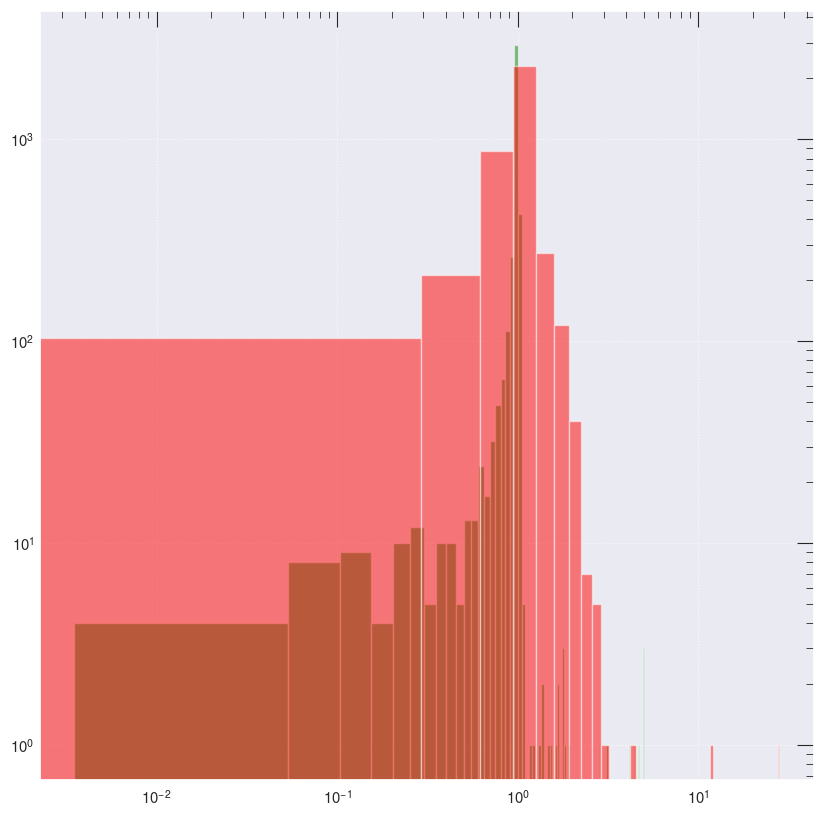

In [14]:
fig, ax = plt.subplots()
ax.hist(frac_track[track_filter].clip(max=5), bins=100, color="green", label="with track - Pandora", alpha=0.5)
ax.hist(frac_pred[track_filter], bins=100, color="red", label="with track", alpha=0.5)
ax.set_yscale("log")
ax.set_xscale("log")
fig.show()

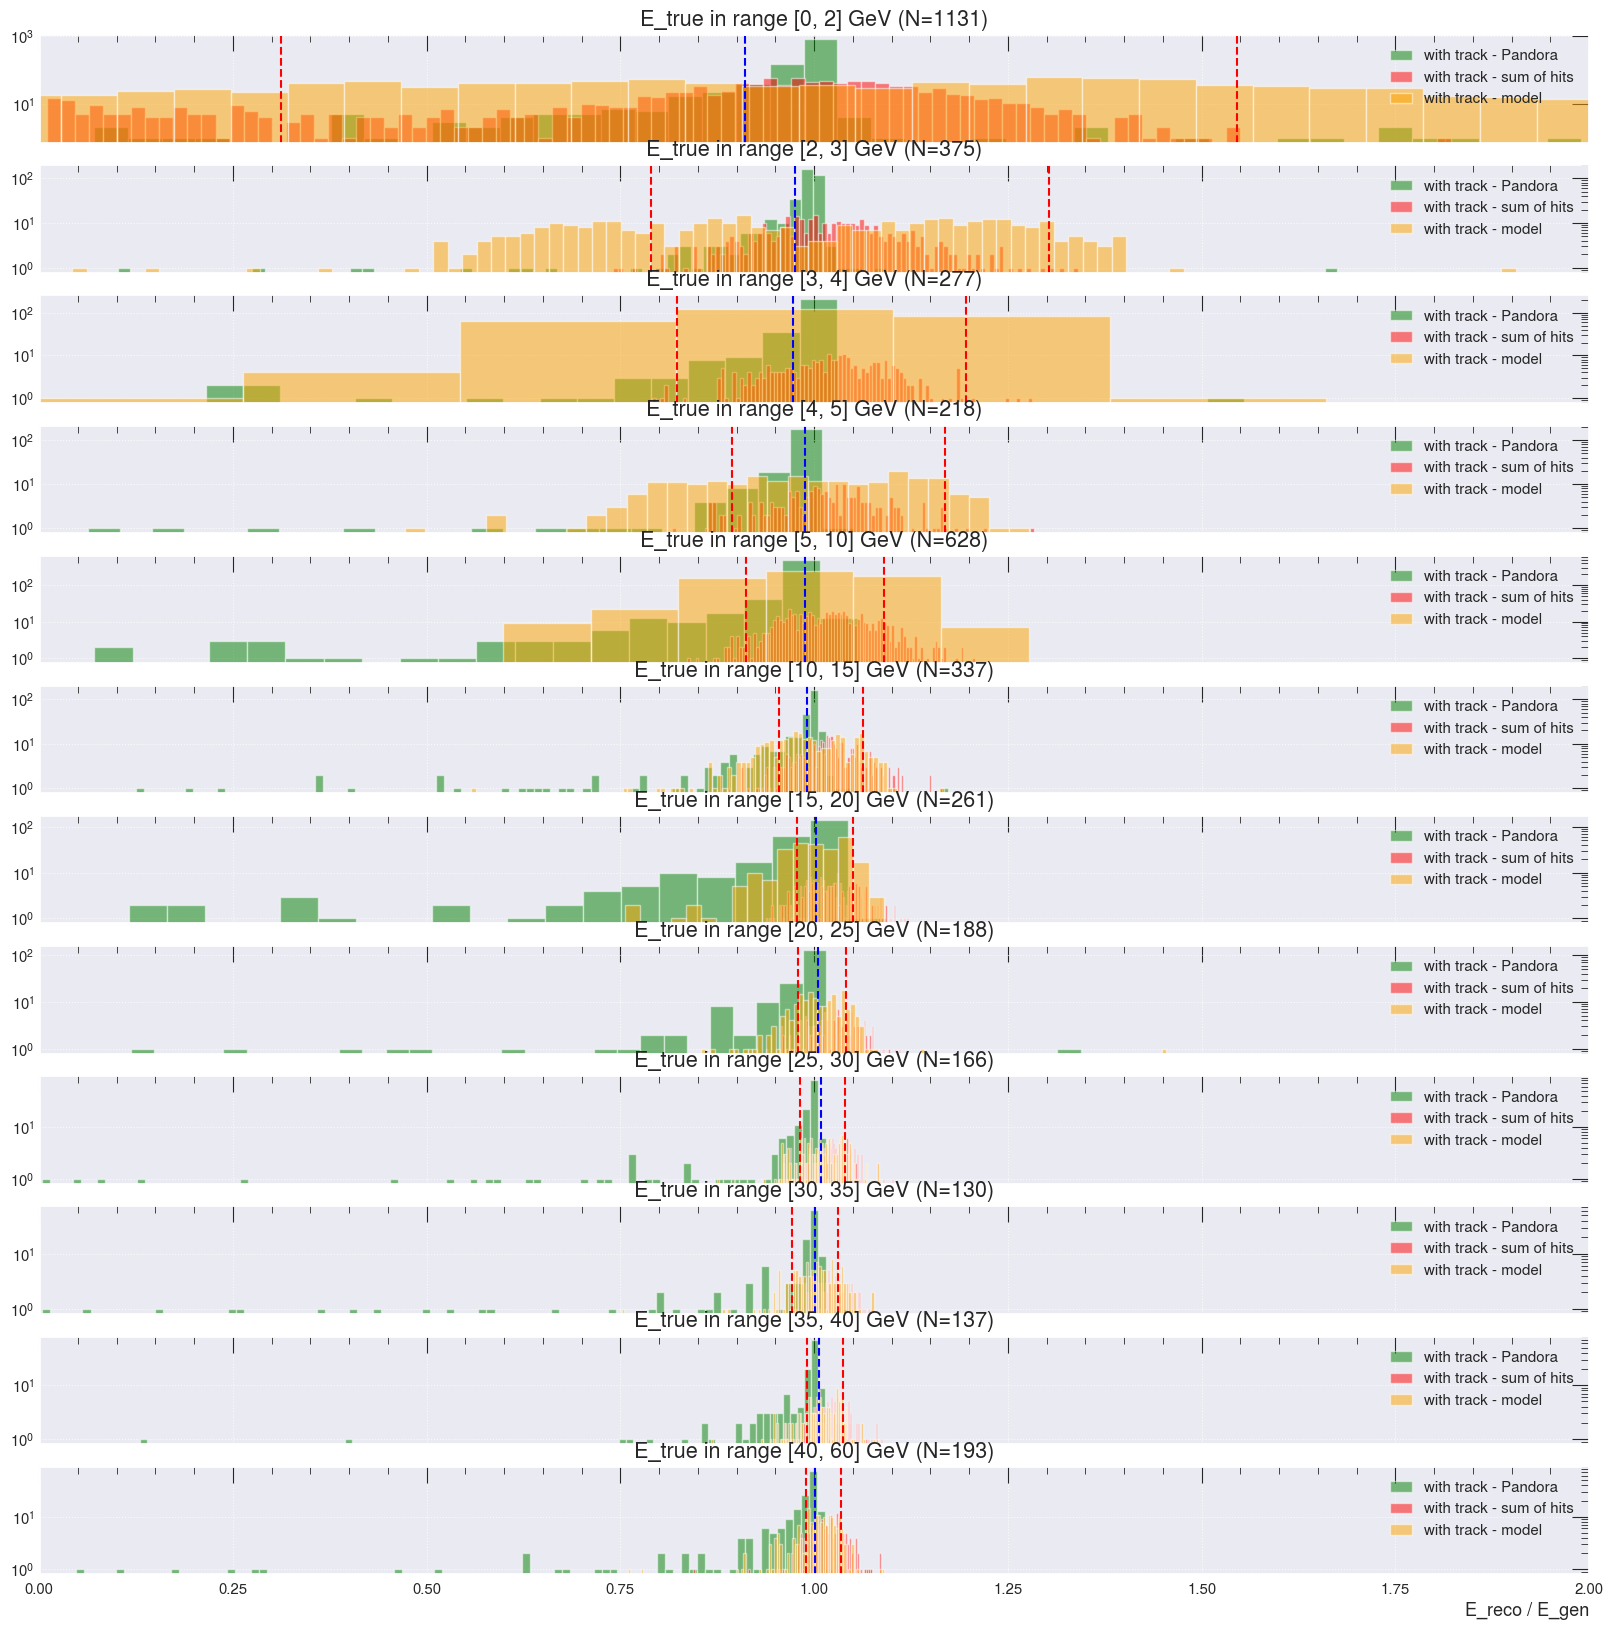

In [15]:
# Now do histograms for different energy bins: 1-2 GeV, 2-5 GeV, 5-10 GeV, 10+ GeV
# distribution of energy corr factor
e_thresholds = [0, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 60]  # True E thresholds!
# set fig size

mpvs_model, s68s_model = [], []
mpvs_pandora, s68s_pandora = [], []
mpvs_sum_hits, s68s_sum_hits = [], []
mpvs_model_normalized, mpvs_pandora_normalized, mpvs_normalized_sum_hits = [], [], []

e_true = (1+yt_regression) * split_regression[1][:, 6].numpy()
e_pred = yp_regression
frac_pred = e_pred / e_true
frac_e_sum = split_regression[1][:, 6].clone().detach().cpu().numpy() / e_true
e_track = split_regression[1][:, 3].clone().detach().cpu().numpy()
frac_track = e_track / e_true
track_filter = ((split_regression[1][:, 3] > 0) & (split_regression[1][:, 7] == 1))
track_filter = track_filter & (split_regression[-1] == 11).cpu()
#not_track_filter = ~track_filter
fig, ax = plt.subplots(len(e_thresholds) - 1, sharex=True, figsize=(20, 20))
binsize = 0.01

for i, e_threshold in enumerate(e_thresholds):
    if i == 0:
        continue
    filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
    ax[i-1].hist(frac_track.clip(max=5)[track_filter & filt_energy], bins=100, color="green", label="with track - Pandora", alpha=0.5)
    ax[i-1].hist(frac_e_sum[track_filter & filt_energy], bins=100, color="red", label="with track - sum of hits", alpha=0.5)
    ax[i-1].hist(frac_pred[track_filter & filt_energy], bins=100, color="orange", label="with track - model", alpha=0.5)
    mpv, s68, lo, hi = obtain_MPV_and_68(e_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
    mpvs_model, s68s_model = mpvs_model + [mpv], s68s_model + [s68]
    mpv, _, lo, hi = obtain_MPV_and_68(frac_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
    mpvs_model_normalized.append(mpv)
    ax[i-1].axvline(lo, color="red", linestyle="--")
    ax[i-1].axvline(hi, color="red", linestyle="--")
    ax[i-1].axvline(mpv, color="blue", linestyle="--")
    mpv, s68, _, _ = obtain_MPV_and_68(e_track[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
    mpvs_pandora, s68s_pandora = mpvs_pandora + [mpv], s68s_pandora + [s68]
    mpv, _, lo, hi = obtain_MPV_and_68(frac_track[filt_energy & track_filter].clip(max=5), bins_per_binned_E=np.arange(0, 5, binsize))
    #print("lo hi", lo, hi)
    
    mpvs_pandora_normalized.append(mpv)
    mpv, s68, _, _ = obtain_MPV_and_68(split_regression[1][:, 6].clone().detach().cpu().numpy()[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
    mpvs_sum_hits, s68s_sum_hits = mpvs_sum_hits + [mpv], s68s_sum_hits + [s68]
    mpv, _, _, _= obtain_MPV_and_68(frac_e_sum[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
    mpvs_normalized_sum_hits.append(mpv)
    #print("mpvs sum hits", mpvs_sum_hits)
    #print("mpvs normalized sum hits", mpv)
    ax[i-1].set_xlim([-1,3])
    ax[i-1].set_title(f"E_true in range [{e_thresholds[i-1]}, {e_thresholds[i]}] GeV (N={(filt_energy & track_filter).sum()})")
    ax[i-1].set_yscale("log")
    ax[i-1].legend()
    ax[i-1].set_xlim([0, 2])
ax[-1].set_xlabel("E_reco / E_gen")
#fig.savefig("/eos/user/g/gkrzmanc/2024/12_3_/frac_hist_tracks_Regression_withexactly1track_2_with_XYZ.pdf"
fig.show()


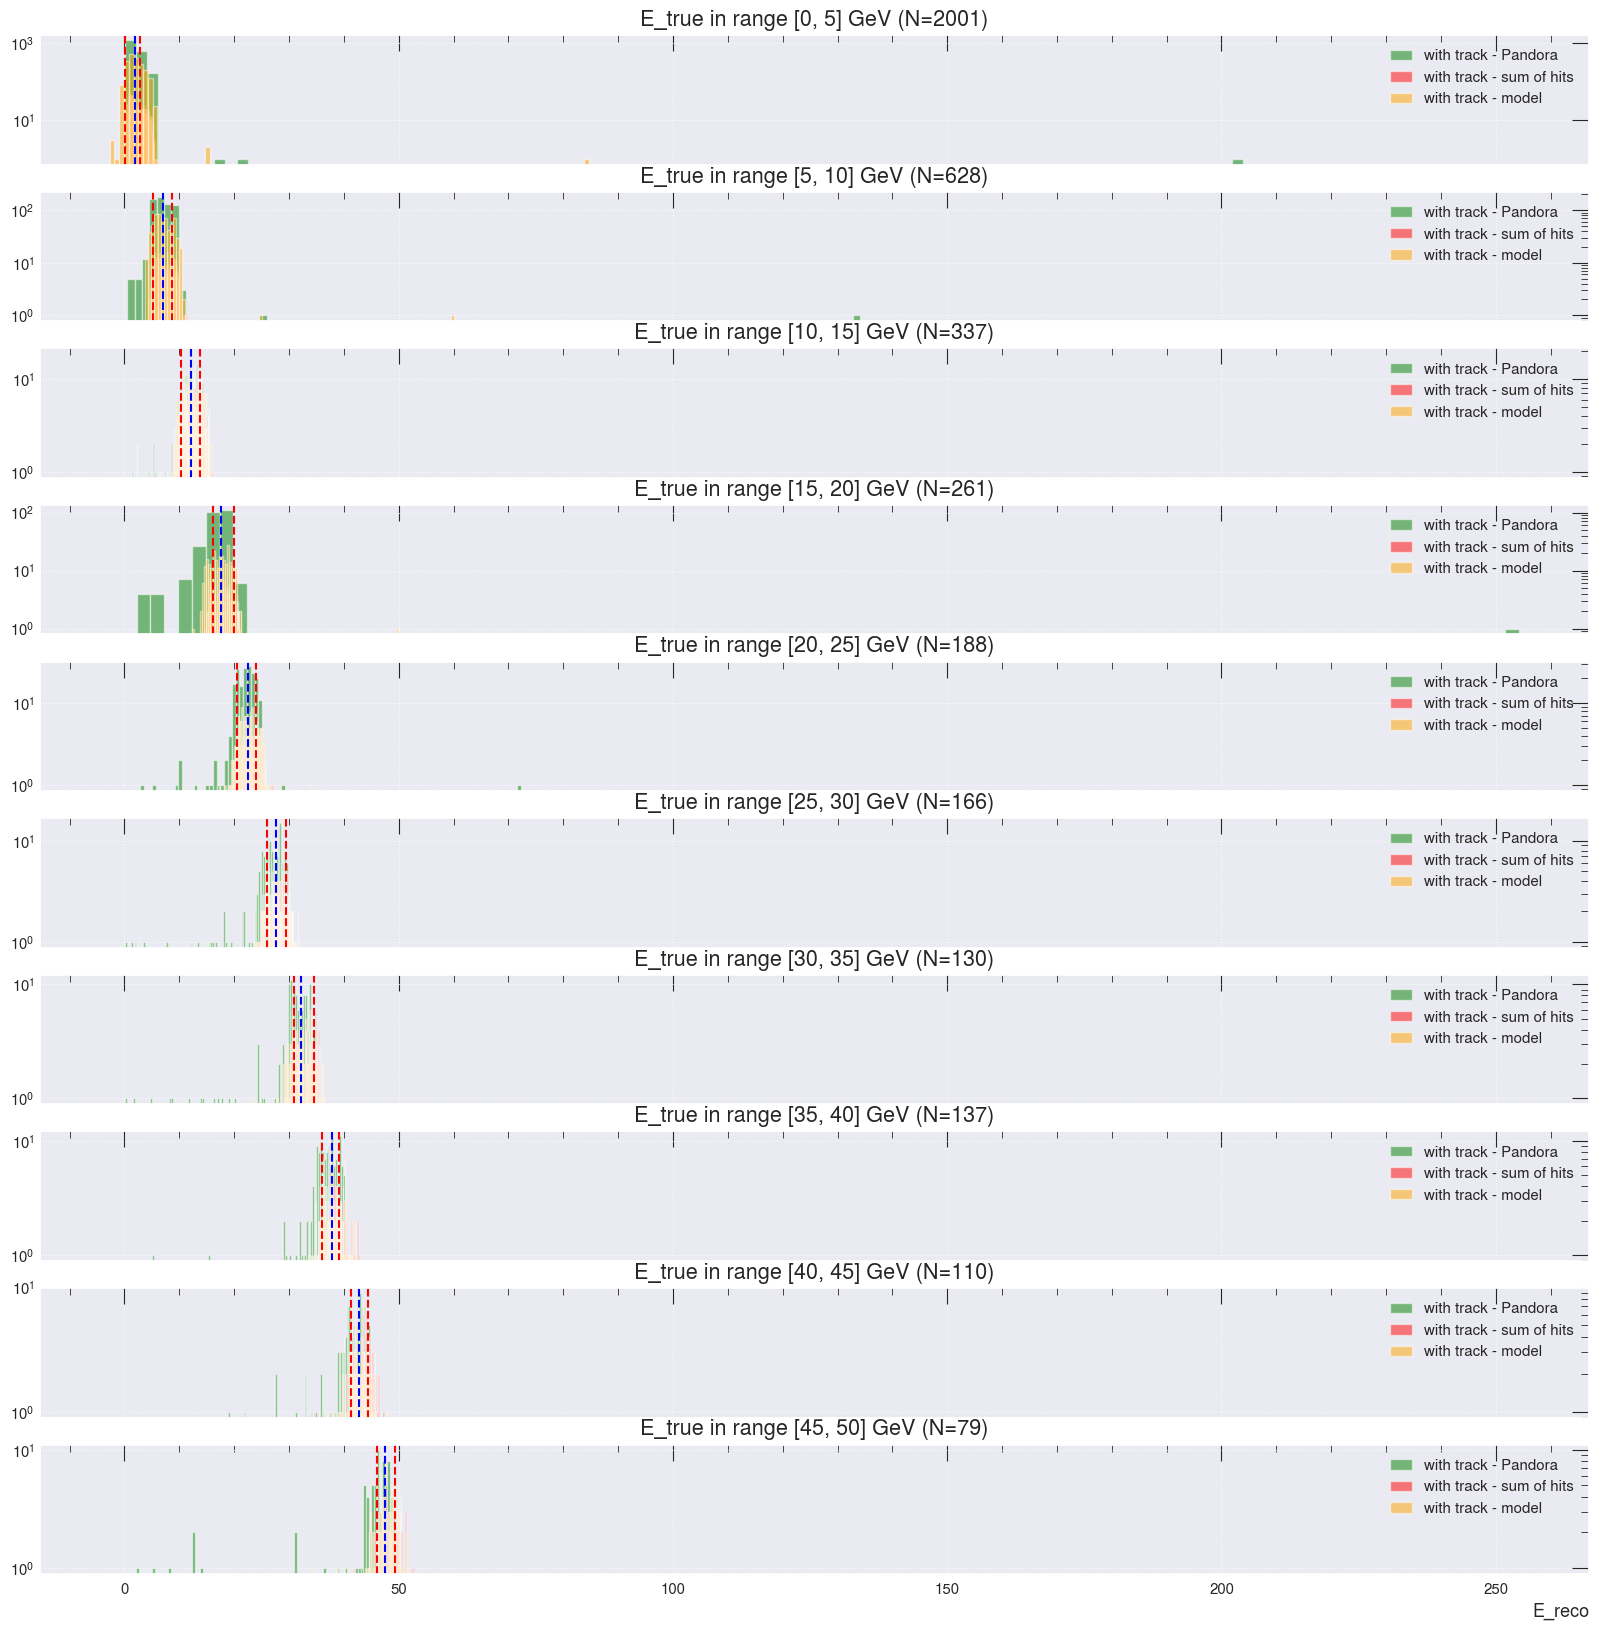

In [16]:
# Same as above but with plots for E_reco only.
# Now do histograms for different energy bins: 1-2 GeV, 2-5 GeV, 5-10 GeV, 10+ GeV
# distribution of energy corr factor
e_thresholds = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]  # True E thresholds!
# set fig size

mpvs_model, s68s_model = [], []
mpvs_pandora, s68s_pandora = [], []
mpvs_sum_hits, s68s_sum_hits = [], []
mpvs_model_normalized, mpvs_pandora_normalized, mpvs_normalized_sum_hits = [], [], []

e_true = (1+yt_regression) * split_regression[1][:, 6].numpy()
e_pred = yp_regression
frac_pred = e_pred / e_true
frac_e_sum = split_regression[1][:, 6].clone().detach().cpu().numpy() / e_true
e_track = split_regression[1][:, 3].clone().detach().cpu().numpy()
frac_track = e_track / e_true
track_filter = ((split_regression[1][:, 3] > 0) & (split_regression[1][:, 7] == 1))
track_filter = track_filter & (split_regression[-1] == 11).cpu()
#not_track_filter = ~track_filter
fig, ax = plt.subplots(len(e_thresholds) - 1, sharex=True, figsize=(20, 20))
binsize = 0.01

for i, e_threshold in enumerate(e_thresholds):
    if i == 0:
        continue
    filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
    ax[i-1].hist((frac_track*e_true)[track_filter & filt_energy], bins=100, color="green", label="with track - Pandora", alpha=0.5)
    ax[i-1].hist((frac_e_sum*e_true)[track_filter & filt_energy], bins=100, color="red", label="with track - sum of hits", alpha=0.5)
    ax[i-1].hist((frac_pred*e_true)[track_filter & filt_energy], bins=100, color="orange", label="with track - model", alpha=0.5)
    mpv, s68, lo, hi = obtain_MPV_and_68(e_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
    ax[i-1].axvline(lo, color="red", linestyle="--")
    ax[i-1].axvline(hi, color="red", linestyle="--")
    ax[i-1].axvline(mpv, color="blue", linestyle="--")
    mpvs_model, s68s_model = mpvs_model + [mpv], s68s_model + [s68]
    mpv, _, lo, hi = obtain_MPV_and_68(frac_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
    mpvs_model_normalized.append(mpv)
    
    mpv, s68, _, _ = obtain_MPV_and_68(e_track[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
    mpvs_pandora, s68s_pandora = mpvs_pandora + [mpv], s68s_pandora + [s68]
    mpv, _, lo, hi = obtain_MPV_and_68(frac_track[filt_energy & track_filter].clip(max=5), bins_per_binned_E=np.arange(0, 5, binsize))
    #print("lo hi", lo, hi)
    mpvs_pandora_normalized.append(mpv)
    mpv, s68, _, _ = obtain_MPV_and_68(split_regression[1][:, 6].clone().detach().cpu().numpy()[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
    mpvs_sum_hits, s68s_sum_hits = mpvs_sum_hits + [mpv], s68s_sum_hits + [s68]
    mpv, _, _, _= obtain_MPV_and_68(frac_e_sum[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
    mpvs_normalized_sum_hits.append(mpv)
    ax[i-1].set_title(f"E_true in range [{e_thresholds[i-1]}, {e_thresholds[i]}] GeV (N={(filt_energy & track_filter).sum()})")
    ax[i-1].set_yscale("log")
    ax[i-1].legend()
ax[-1].set_xlabel("E_reco")
#fig.savefig("/eos/user/g/gkrzmanc/2024/12_3_/frac_hist_tracks_Regression_withexactly1track_2_with_XYZ.pdf"
fig.show()


In [19]:
filt_energy = (e_true < 3) & (e_true >= 2)
f = frac_track[filt_energy & track_filter]
obtain_MPV_and_68(f, bins_per_binned_E=np.linspace(f.min(), f.max(), 1000))

(0.9858463, 0.00871331603438763, 0.9864498070171765, 1.0038764390859518)

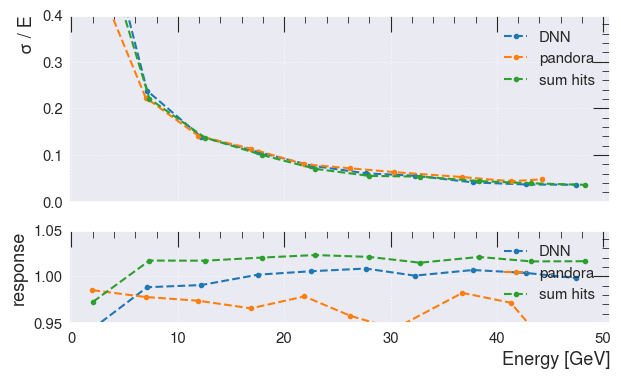

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots. 
ax[0].plot(mpvs_model, np.array(s68s_model) / np.array(mpvs_model), ".--", label="DNN")
ax[0].plot(mpvs_pandora, np.array(s68s_pandora) / np.array(mpvs_pandora), ".--", label="pandora")
ax[0].plot(mpvs_sum_hits, np.array(s68s_sum_hits) / np.array(mpvs_sum_hits), ".--", label="sum hits")
ax[0].legend()
ax[1].set_xlabel("Energy [GeV]")
ax[0].set_ylabel("σ / E")
ax[0].set_ylim([0, 0.4])
ax[1].plot(mpvs_model, mpvs_model_normalized, ".--", label="DNN")
ax[1].plot(mpvs_pandora, mpvs_pandora_normalized, ".--", label="pandora")
ax[1].plot(mpvs_sum_hits, mpvs_normalized_sum_hits, ".--", label="sum hits")
ax[1].legend()
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")
#fig.savefig("/eos/user/g/gkrzmanc/2024/12_3_/response_and_resolution_tracks_Regression_1track_only_2_with_XYZ.pdf")
fig.show()


In [ ]:
frac_pred[track_filter].max()

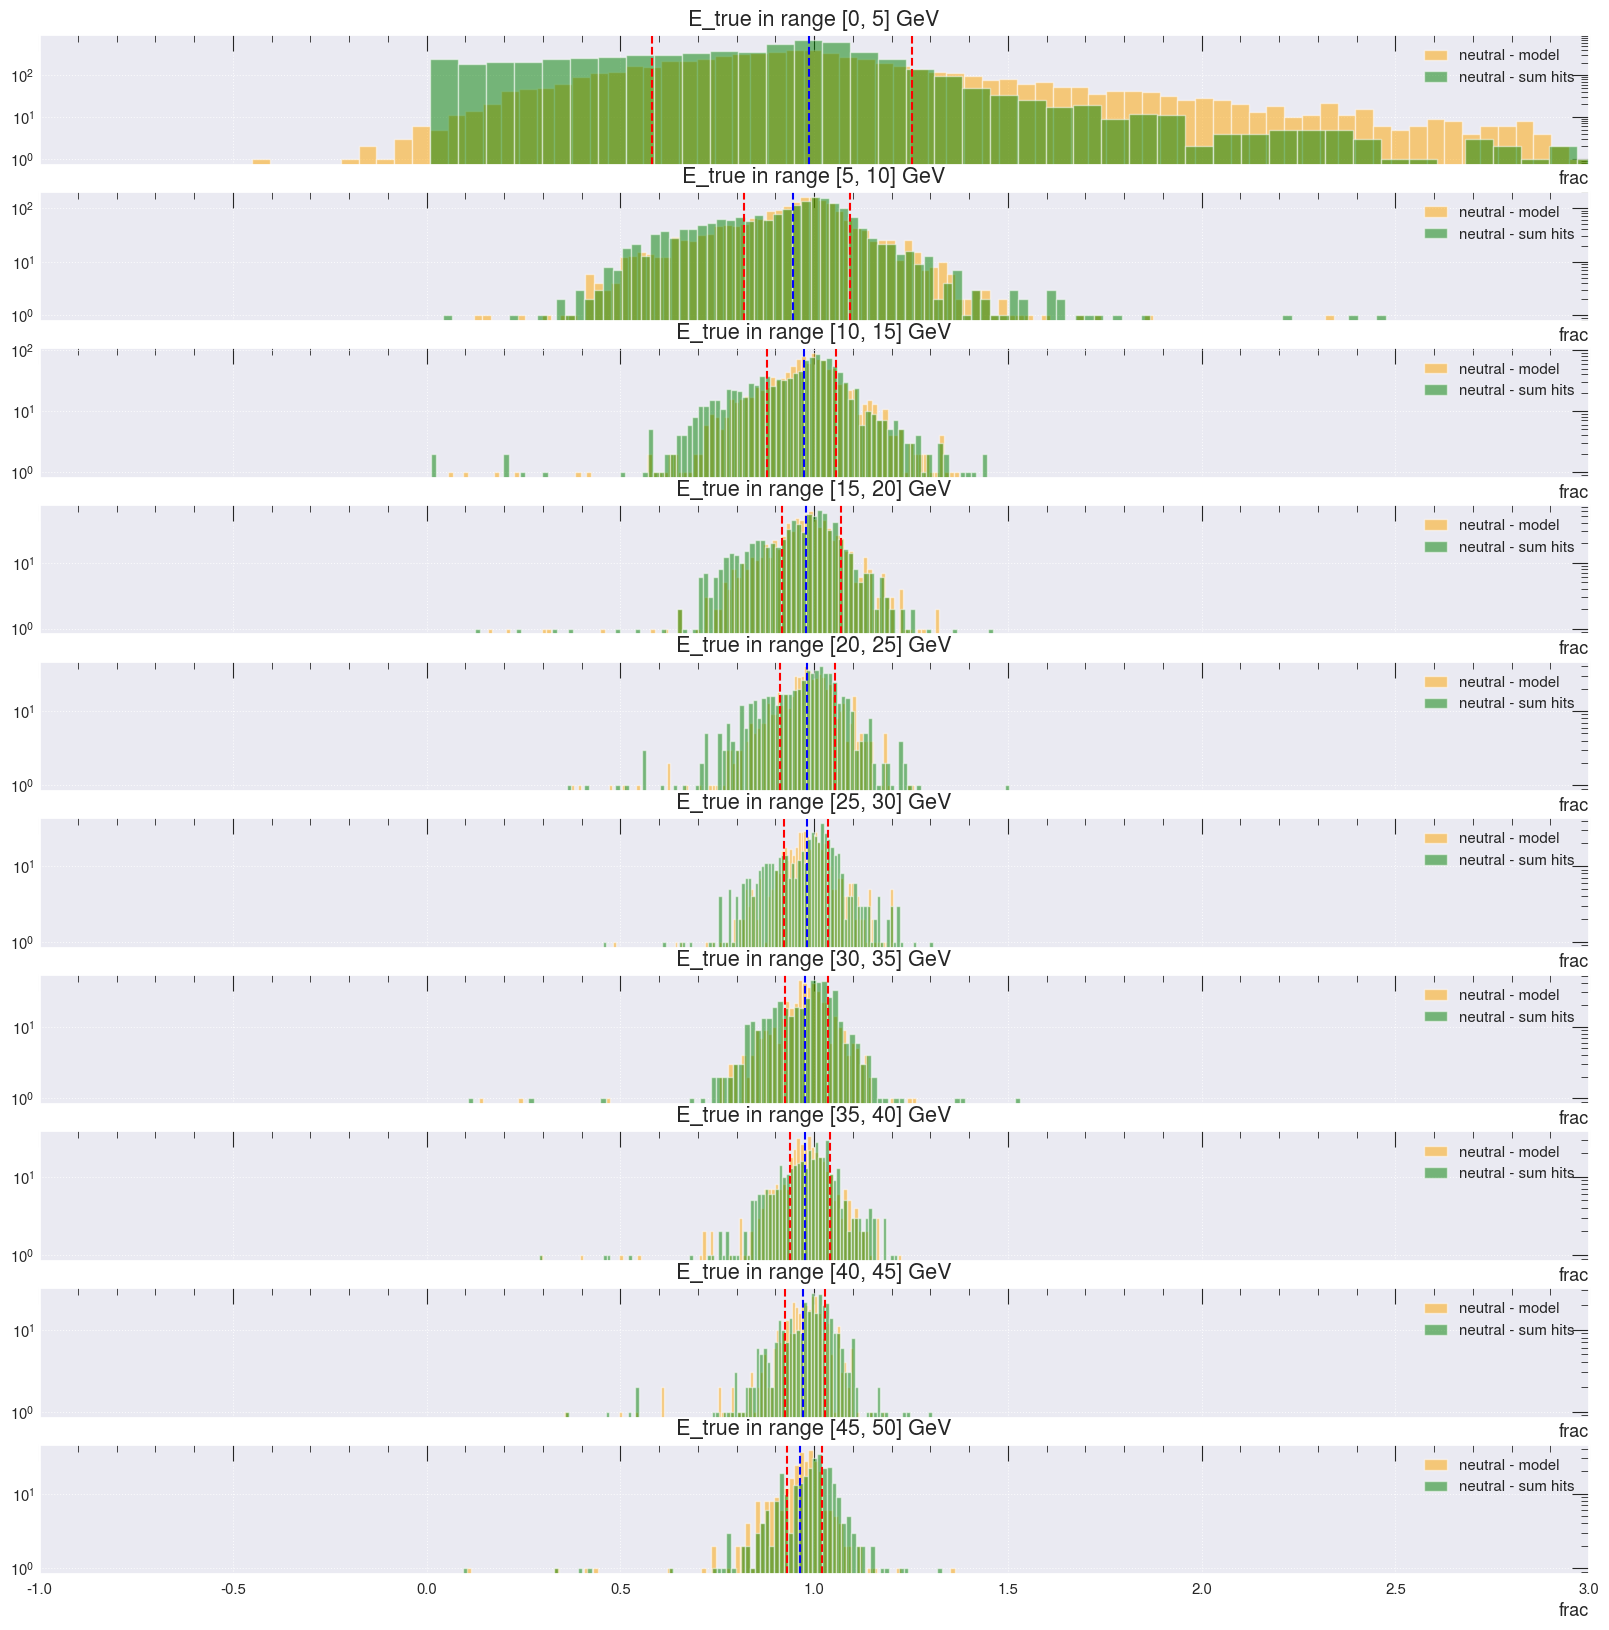

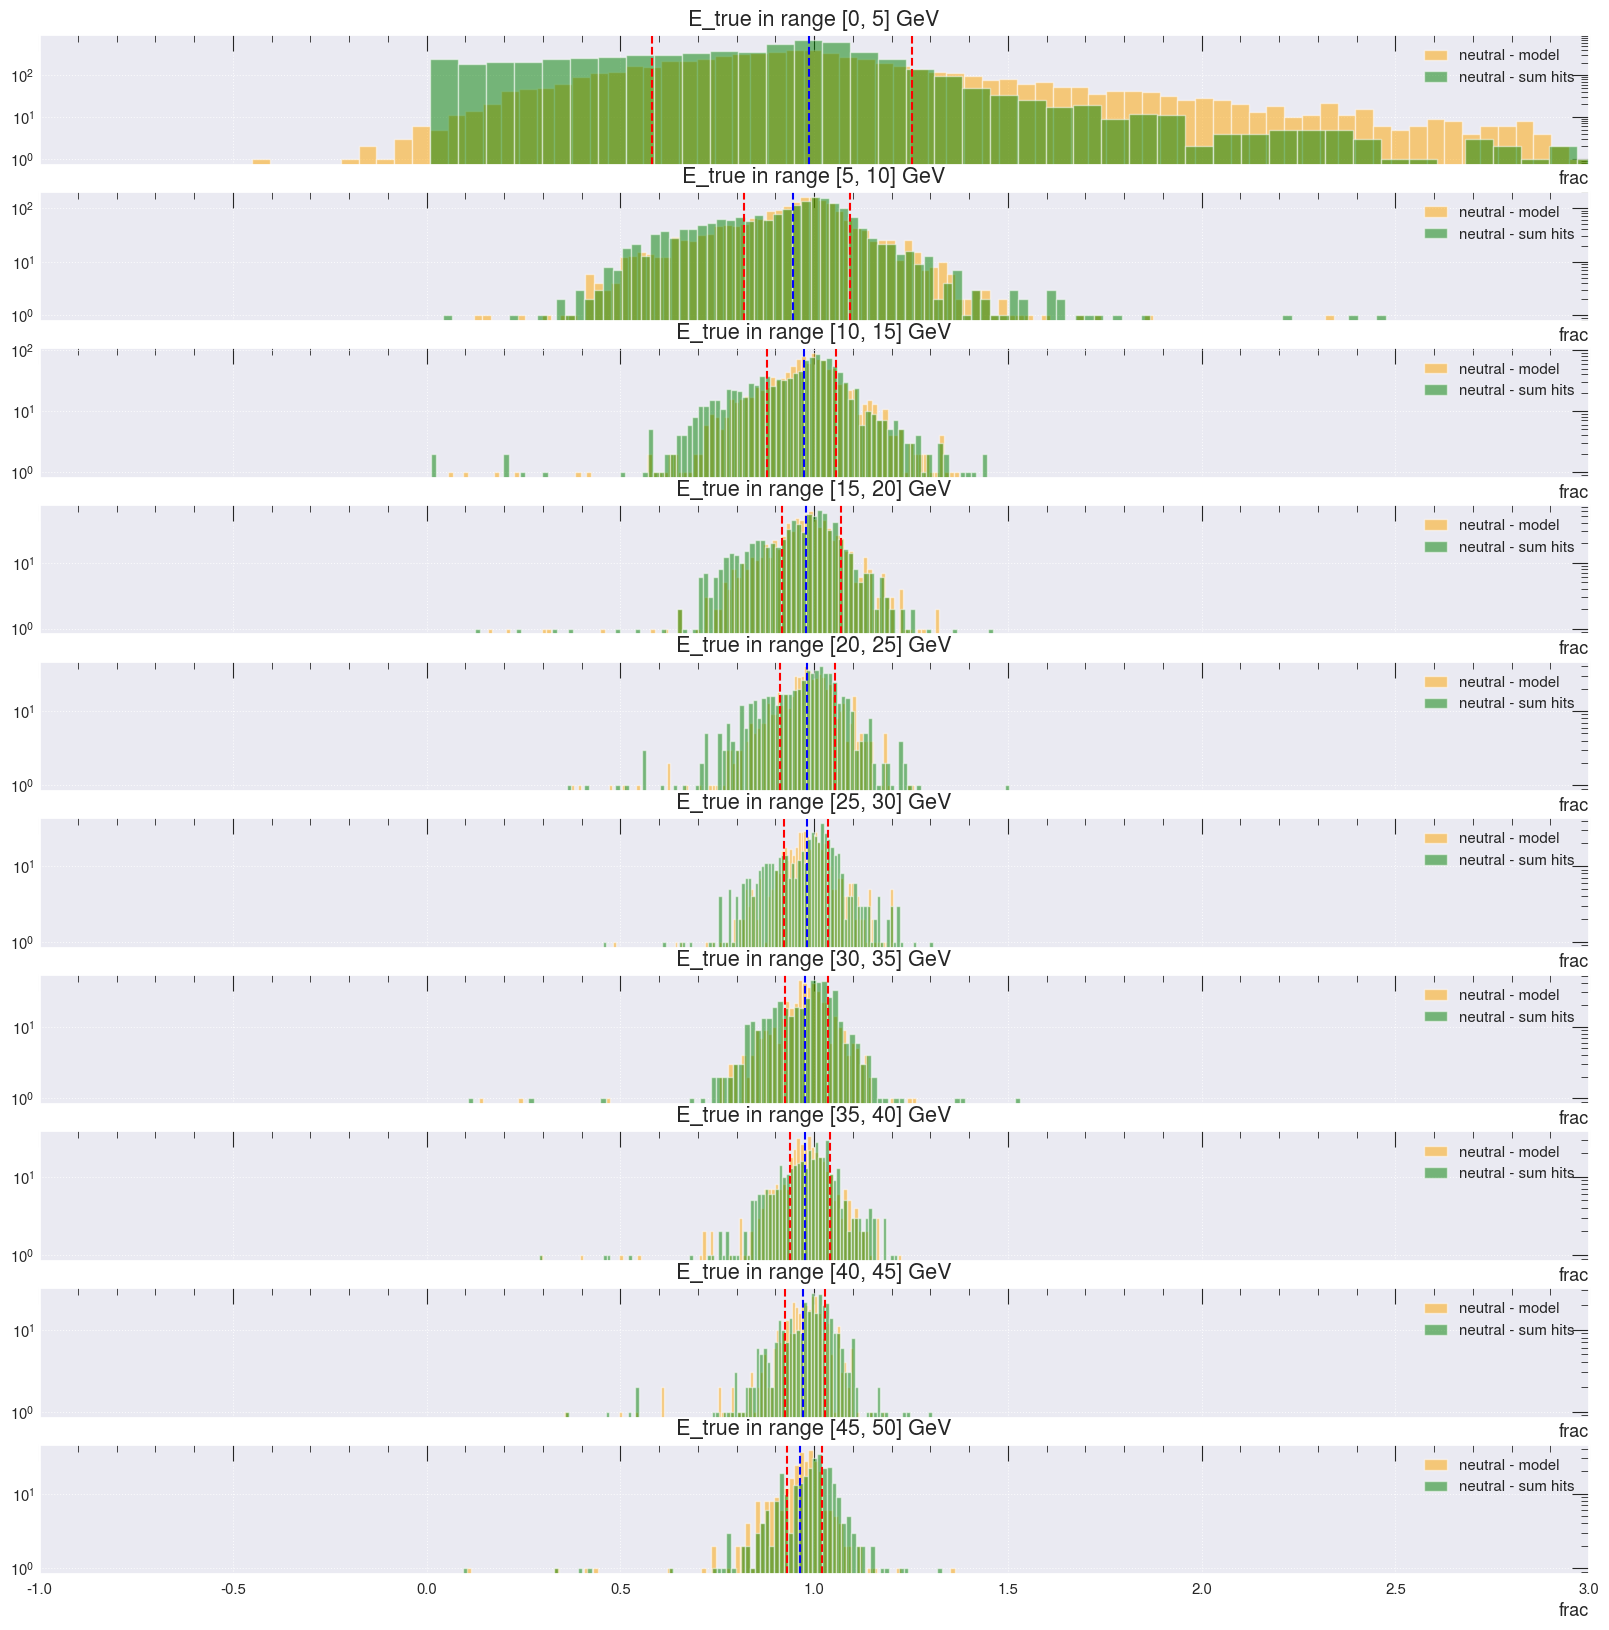

In [24]:
e_thresholds = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] 
# Now do histograms for different energy bins: 1-2 GeV, 2-5 GeV, 5-10 GeV, 10+ GeV
# distribution of energy corr factor

#e_thresholds = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 60]  # True E thresholds!

# set fig size
mpvs_model, s68s_model = [], []
mpvs_pandora, s68s_pandora = [], []
mpvs_normalized_model, mpvs_normalized_sumhits = [], []
s68s_sum_hits = []
mpvs_sum_hits = []
e_true = (1+neutral_yt) * neutral_split[1][:, 6].numpy()
e_pred = neutral_yp  # Regression # # (1+neutral_yp) * neutral_split[1][:, 6].numpy()
frac_pred = e_pred / e_true
e_hits = neutral_split[1][:, 6].clone().detach().cpu().numpy()
frac_sum_hits = e_hits / e_true
not_track_filter = ((neutral_split[1][:, 3] == 0) & (neutral_split[1][:, 7] == 0))
eps = 0.02
fig, ax = plt.subplots(len(e_thresholds) - 1, figsize=(20, 20), sharex=True)
for i, e_threshold in enumerate(e_thresholds):
    if i == 0:
        continue
    filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
    #print("sum", filt_energy.sum())
    ax[i-1].hist(frac_pred[not_track_filter & filt_energy], bins=100, color="orange", label="neutral - model", alpha=0.5)
    ax[i-1].hist(frac_sum_hits[not_track_filter & filt_energy], bins=100, color="green", label="neutral - sum hits", alpha=0.5)
    mpv, s68, _, _ = obtain_MPV_and_68(e_pred[not_track_filter & filt_energy], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], eps))
    mpvs_model, s68s_model = mpvs_model + [mpv], s68s_model + [s68]
    mpv, _ , lo, hi = obtain_MPV_and_68(frac_pred[not_track_filter & filt_energy], bins_per_binned_E=np.arange(0, 5, eps))
    ax[i-1].axvline(mpv, color="blue", linestyle="--")
    mpvs_normalized_model.append(mpv)
    mpv, s68, _, _ = obtain_MPV_and_68(e_hits[not_track_filter & filt_energy], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], eps))
    mpvs_pandora, s68s_pandora = mpvs_pandora + [mpv], s68s_pandora + [s68]
    mpvs_sum_hits.append(mpv)
    s68s_sum_hits.append(s68)
    mpv, _, _, _ = obtain_MPV_and_68(frac_sum_hits[not_track_filter & filt_energy], bins_per_binned_E=np.arange(0, 5, eps))
    mpvs_normalized_sumhits.append(mpv)
    
    # only hadronic
    # vertical red lines at lo and hi
    ax[i-1].axvline(lo, color="red", linestyle="--")    
    ax[i-1].axvline(hi, color="red", linestyle="--")
    # blue line at mpv
    ax[i-1].set_xlabel("frac")
    ax[i-1].set_xlim([-1,3])
    ax[i-1].set_title(f"E_true in range [{e_thresholds[i-1]}, {e_thresholds[i]}] GeV")
    # log x axis
    ax[i-1].set_yscale("log")
    ax[i-1].legend()
#fig.savefig("/eos/home-g/gkrzmanc/2024/12_3_/frac_hist_neutral_regression2_with_lo_hi_different_mean.pdf")  # calculate mean, not the most probable value - seems it is a bit sensitive to the binning, especially now since we don't have this much data
#fig.show()
fig

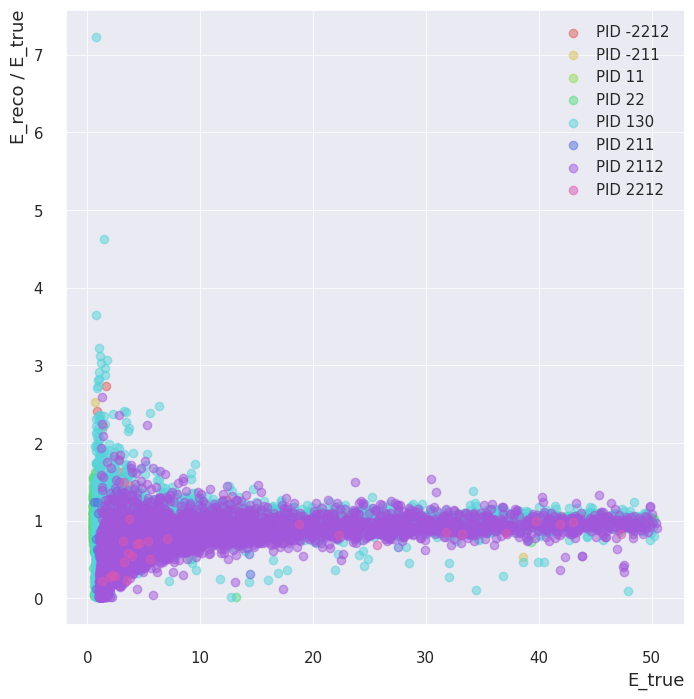

In [151]:
fig, ax = plt.subplots(figsize=(8,8))
# scatter of e_true and frac_pred
pids = neutral_split[-1][not_track_filter].clone().detach().cpu().numpy()
pids = pids.astype(int)
unique_pids = np.unique(pids)
pids_idx = [np.where(pids == pid)[0] for pid in unique_pids]
pids_colors_mapping = {pid: color for pid, color in zip(unique_pids, sns.color_palette("hls", len(unique_pids)))}
for pid in unique_pids:
    #if pid != 2212:
    #    continue
    mask = pids == pid
    ax.scatter(e_true[not_track_filter][mask], (e_hits / e_true)[not_track_filter][mask], alpha=0.5, color=pids_colors_mapping[pid], label=f"PID {pid}")
#ax.scatter(e_true[not_track_filter], (e_hits / e_true)[not_track_filter], alpha=0.02, color = [pids_colors_mapping[pid] for pid in pids])
ax.legend()
# color by pid

ax.set_xlabel("E_true")
ax.set_ylabel("E_reco / E_true")
#ax.set_xscale("log")
#ax.set_xlim([0, 5])
#ax.set_ylim([0, 2])
fig.show()


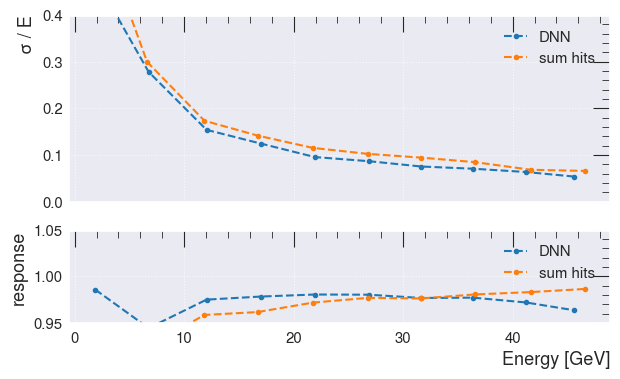

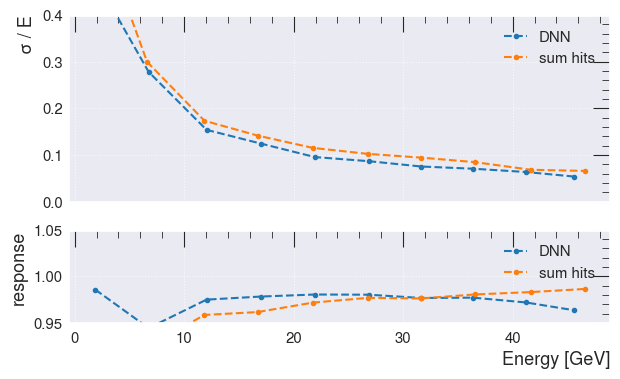

In [40]:
# cut mpvs_sum_hits in half (only keep 1st half of array)
#mpvs_sum_hits = mpvs_sum_hits[:len(mpvs_sum_hits)//2]
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
ax[0].plot(mpvs_model, np.array(s68s_model) / np.array(mpvs_model), ".--", label="DNN")
ax[0].plot(mpvs_sum_hits, np.array(s68s_sum_hits) / np.array(mpvs_sum_hits), ".--", label="sum hits")
ax[0].legend()
ax[1].set_xlabel("Energy [GeV]")
ax[0].set_ylabel("σ / E")
ax[0].set_ylim([0, 0.4])
ax[1].plot(mpvs_model, mpvs_normalized_model, ".--", label="DNN")
ax[1].plot(mpvs_sum_hits, mpvs_normalized_sumhits, ".--", label="sum hits")
ax[1].legend()
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")
#fig.savefig("/eos/user/g/gkrzmanc/2024/12_3_/response_and_resolution_Neutral_Regression_1track_only_2_with_XYZ_mean_3percent_1.pdf")
fig


In [40]:
split_regression[-1].unique()

tensor([-2212.,  -211.,    11.,    22.,   130.,   211.,  2112.,  2212.],
       device='cuda:3')

In [38]:

def get_charged_response_resol_plot_for_PID(pid):
    e_thresholds = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]  # True E thresholds!    
    mpvs_model, s68s_model = [], []
    mpvs_pandora, s68s_pandora = [], []
    mpvs_sum_hits, s68s_sum_hits = [], []
    mpvs_model_normalized, mpvs_pandora_normalized, mpvs_normalized_sum_hits = [], [], []
    e_true = (1+yt_regression) * split_regression[1][:, 6].numpy()
    e_pred = yp_regression
    frac_pred = e_pred / e_true
    frac_e_sum = split_regression[1][:, 6].clone().detach().cpu().numpy() / e_true
    e_track = split_regression[1][:, 3].clone().detach().cpu().numpy()
    frac_track = e_track / e_true
    track_filter = ((split_regression[1][:, 3] > 0) & (split_regression[1][:, 7] == 1))
    track_filter = track_filter & (split_regression[-1] == pid).cpu()
    binsize = 0.01
    
    for i, e_threshold in enumerate(e_thresholds):
        if i == 0:
            continue
        filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
        mpv, s68, lo, hi = obtain_MPV_and_68(e_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
        mpvs_model, s68s_model = mpvs_model + [mpv], s68s_model + [s68]
        mpv, _, lo, hi = obtain_MPV_and_68(frac_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
        mpvs_model_normalized.append(mpv)
        
        mpv, s68, _, _ = obtain_MPV_and_68(e_track[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
        mpvs_pandora, s68s_pandora = mpvs_pandora + [mpv], s68s_pandora + [s68]
        mpv, _, lo, hi = obtain_MPV_and_68(frac_track[filt_energy & track_filter].clip(max=5), bins_per_binned_E=np.arange(0, 5, binsize))
        #print("lo hi", lo, hi)
        mpvs_pandora_normalized.append(mpv)
        mpv, s68, _, _ = obtain_MPV_and_68(split_regression[1][:, 6].clone().detach().cpu().numpy()[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
        mpvs_sum_hits, s68s_sum_hits = mpvs_sum_hits + [mpv], s68s_sum_hits + [s68]
        mpv, _, _, _= obtain_MPV_and_68(frac_e_sum[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
        mpvs_normalized_sum_hits.append(mpv)

    
    fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots. 
    ax[0].plot(mpvs_model, np.array(s68s_model) / np.array(mpvs_model), ".--", label="DNN")
    ax[0].plot(mpvs_pandora, np.array(s68s_pandora) / np.array(mpvs_pandora), ".--", label="pandora")
    ax[0].plot(mpvs_sum_hits, np.array(s68s_sum_hits) / np.array(mpvs_sum_hits), ".--", label="sum hits")
    ax[0].legend()
    ax[1].set_xlabel("Energy [GeV]")
    ax[0].set_ylabel("σ / E")
    ax[0].set_ylim([0, 0.4])
    ax[1].plot(mpvs_model, mpvs_model_normalized, ".--", label="DNN")
    ax[1].plot(mpvs_pandora, mpvs_pandora_normalized, ".--", label="pandora")
    ax[1].plot(mpvs_sum_hits, mpvs_normalized_sum_hits, ".--", label="sum hits")
    ax[1].set_ylim([0.95, 1.05])
    ax[1].set_ylabel("response")
    #fig.savefig("/eos/user/g/gkrzmanc/2024/12_3_/response_and_resolution_tracks_Regression_1track_only_2_with_XYZ.pdf")
    return fig

def get_neutral_response_resolution_plot_for_PID(pid):
    e_thresholds = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] 
    # set fig size
    mpvs_model, s68s_model = [], []
    mpvs_pandora, s68s_pandora = [], []
    mpvs_normalized_model, mpvs_normalized_sumhits = [], []
    s68s_sum_hits = []
    mpvs_sum_hits = []
    e_true = (1+neutral_yt) * neutral_split[1][:, 6].numpy()
    e_pred = neutral_yp  # Regression # # (1+neutral_yp) * neutral_split[1][:, 6].numpy()
    frac_pred = e_pred / e_true
    e_hits = neutral_split[1][:, 6].clone().detach().cpu().numpy()
    frac_sum_hits = e_hits / e_true
    not_track_filter = ((neutral_split[1][:, 3] == 0) & (neutral_split[1][:, 7] == 0)) & (neutral_split[-1] == pid).cpu()
    eps = 0.02
    for i, e_threshold in enumerate(e_thresholds):
        if i == 0:
            continue
        filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
        #print("sum", filt_energy.sum())
        mpv, s68, _, _ = obtain_MPV_and_68(e_pred[not_track_filter & filt_energy], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], eps))
        mpvs_model, s68s_model = mpvs_model + [mpv], s68s_model + [s68]
        mpv, _ , lo, hi = obtain_MPV_and_68(frac_pred[not_track_filter & filt_energy], bins_per_binned_E=np.arange(0, 5, eps))
        mpvs_normalized_model.append(mpv)
        mpv, s68, _, _ = obtain_MPV_and_68(e_hits[not_track_filter & filt_energy], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], eps))
        mpvs_pandora, s68s_pandora = mpvs_pandora + [mpv], s68s_pandora + [s68]
        mpvs_sum_hits.append(mpv)
        s68s_sum_hits.append(s68)
        mpv, _, _, _ = obtain_MPV_and_68(frac_sum_hits[not_track_filter & filt_energy], bins_per_binned_E=np.arange(0, 5, eps))
        mpvs_normalized_sumhits.append(mpv)
    # cut mpvs_sum_hits in half (only keep 1st half of array)
    #mpvs_sum_hits = mpvs_sum_hits[:len(mpvs_sum_hits)//2]
    fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
    ax[0].plot(mpvs_model, np.array(s68s_model) / np.array(mpvs_model), ".--", label="DNN")
    ax[0].plot(mpvs_sum_hits, np.array(s68s_sum_hits) / np.array(mpvs_sum_hits), ".--", label="sum hits")
    ax[0].legend()
    ax[1].set_xlabel("Energy [GeV]")
    ax[0].set_ylabel("σ / E")
    ax[0].set_ylim([0, 0.4])
    ax[1].plot(mpvs_model, mpvs_normalized_model, ".--", label="DNN")
    ax[1].plot(mpvs_sum_hits, mpvs_normalized_sumhits, ".--", label="sum hits")
    ax[1].set_ylim([0.95, 1.05])
    ax[1].set_ylabel("response")
    return fig



In [33]:
neutrals = {
    "gamma": 22,
    "Klong": 130,
    "n": 2112
}
charged = {
    "pi+": 211,
    "pi-": -211,
    "p": 2212,
    "antip": -2212,
    "e": 11
}

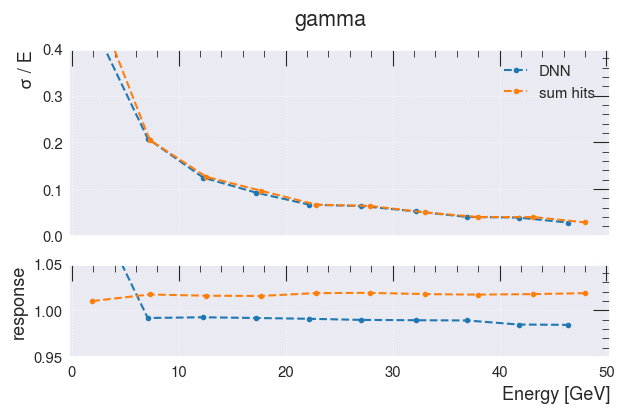

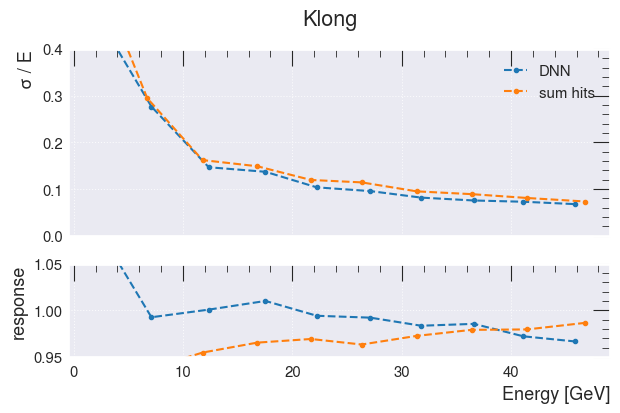

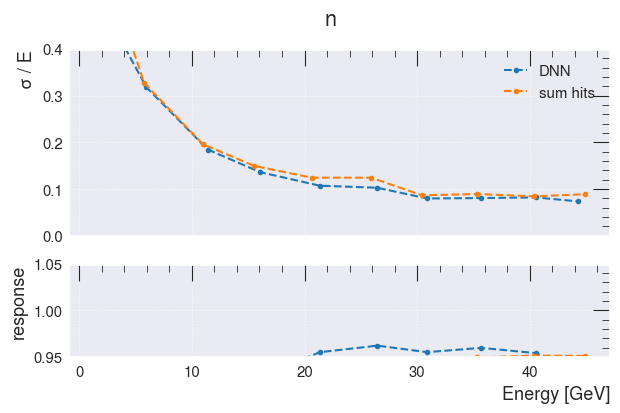

In [34]:
for key in neutrals:
    fig = get_neutral_response_resolution_plot_for_PID(neutrals[key])
    fig.suptitle(key)
    fig.savefig(f"/eos/user/g/gkrzmanc/2024/12_3_/DNN_response_and_resolution_Neutral_Regression_1track_only_2_with_XYZ_mean_3percent_{key}.pdf")
    fig.show()

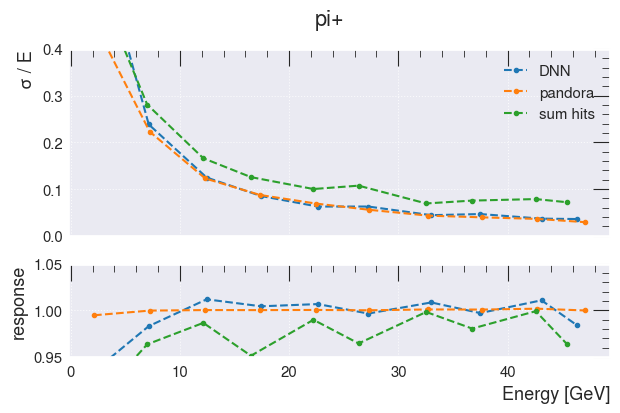

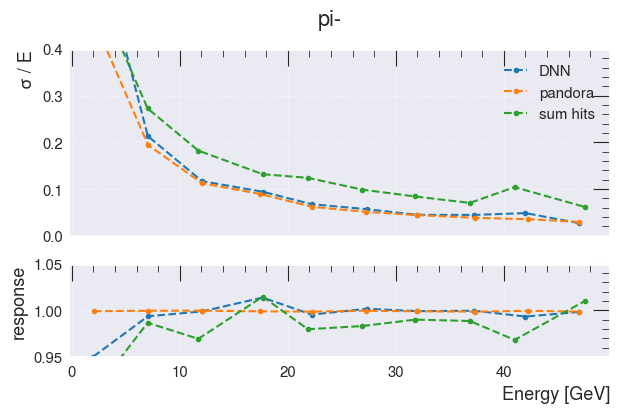

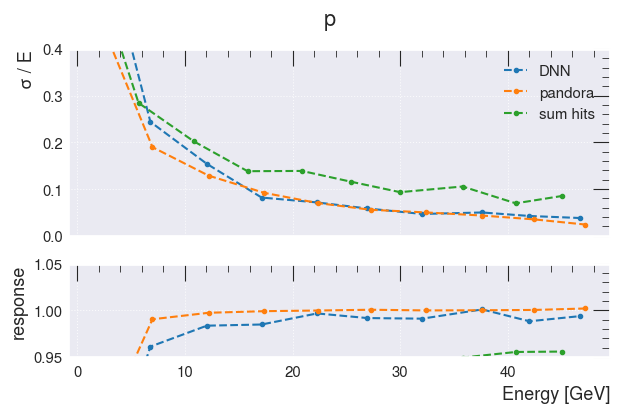

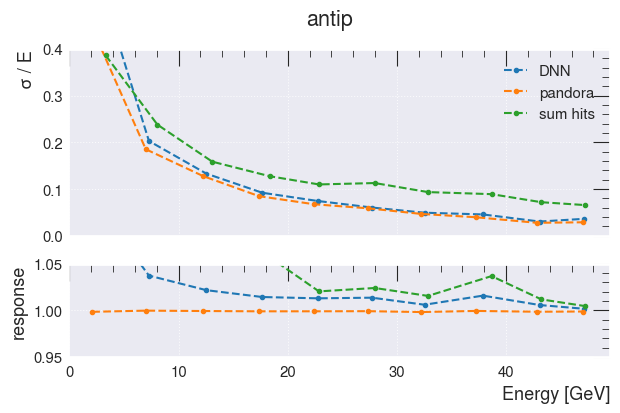

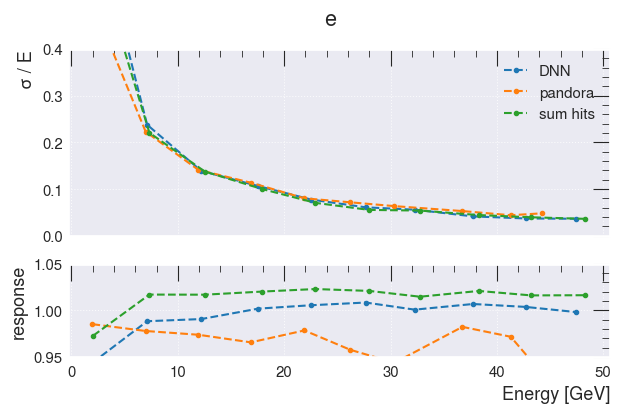

In [39]:
for key in charged:
    fig = get_charged_response_resol_plot_for_PID(charged[key])
    fig.suptitle(key)
    fig.savefig(f"/eos/user/g/gkrzmanc/2024/12_3_/DNN_response_and_resolution_tracks_Regression_1track_only_2_with_XYZ_mean_3percent_{key}.pdf")
    fig.show()
    